In [1]:
#Basic setups 
import numpy as np
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from dataloader import load_data
from PCA import PCA

#Load and preprocess the data
#We change the load_data function by deleting the value assigned to datatype in the definition
aligned_data,cnt = load_data("./aligned/")

Car types: ['Convertible', 'Minivan', 'Pickup', 'Sedan'] 

Convertible: 149 # of images
Minivan: 148 # of images
Pickup: 150 # of images
Sedan: 150 # of images


In [3]:

from random import shuffle
import math
def kFold(K,data):
    """This function is used to implement k-fold cross-validation"""
    #Shuffle the dataset to get more accurate performance
    index = np.arange(0,len(data))
    shuffled_idx = np.random.shuffle(index)
    shuffled_data_temp = data[shuffled_idx]
    shuffled_data = shuffled_data_temp[0,:,:]
    
    print("original shape:",data.shape)
    print("shuffled shape:",shuffled_data.shape)
    
    #Split the data into training, testing and handout set
    size = len(data)
    set_size = math.floor(size/K)
    index_train = int(set_size*(K-2))
    index_test = int(set_size*(K-1))

    
    training_set = shuffled_data[:index_train]
    testing_set = shuffled_data[index_train:index_test]
    val_set = shuffled_data[index_test:]
    print("trainshape:",training_set.shape)
    return training_set,testing_set,val_set



In [4]:
def dataSplit(K,data):
    """This function is used to implement k-fold cross-validation"""
    #Shuffle the dataset to get more accurate performance
    index = np.arange(0,len(data))
    shuffled_idx = np.random.shuffle(index)
    shuffled_data = data[shuffled_idx]
    
    #Split the data into training, testing and handout set
    size = len(data)
    set_size = math.floor(size/K)
    folds = []
    for i in range(K-1):
        temp = data[i*set_size:(i+1)*set_size,:]
        folds.append(temp)
    folds.append(data[K*set_size:,:])
    return folds

In [5]:
def img_flatten(img):
    """This function is used to convert 2-D images to 1-D vectors"""
    flatten_img = []
    for i in range(len(img)):
        flatten_img.append(img[i].flatten())
    return np.array(flatten_img)

In [6]:
def plot_top_PCs(eigenvectors,n):
    imgs = []
    plt.figure()
    for i in range(n):
        eigen = egenvectors[i]
        image = np.reshape(eigen,(200,300))
        image = Image.fromarray(image)
        imgs.append(img)
        plt.subplot(1,n,i)
        plt.imshow(imgs[i])

In [185]:
def projectPC(x,mean_image, top_sqrt_eigen_values, top_eigen_vectors):
    """This function is used to project the data x on the given training set x_train"""
    
    msd = x - mean_image
    projected_image = np.matmul(msd,top_eigen_vectors)/top_sqrt_eigen_values
    projected = np.insert(projected_image,0,1,axis=1)
    return projected

In [186]:
#Load data 
resized_data,resize_cnt = load_data("./resized/")

num_PC = 14
minivan_resize = resized_data.get('Minivan')
convertible_resize = resized_data.get('Convertible')

minivan_resize_flatten = img_flatten(minivan_resize)
convertible_resize_flatten = img_flatten(convertible_resize)

num_fold = 10
trainM_resize,testM_resize,valM_resize = kFold(num_fold,minivan_resize_flatten)
trainC_resize,testC_resize,valC_resize = kFold(num_fold,convertible_resize_flatten)

print("trainM_resize shape:",trainM_resize.shape)

Car types: ['Convertible', 'Minivan'] 

Convertible: 150 # of images
Minivan: 150 # of images
original shape: (150, 60000)
shuffled shape: (150, 60000)
trainshape: (120, 60000)
original shape: (150, 60000)
shuffled shape: (150, 60000)
trainshape: (120, 60000)
trainM_resize shape: (120, 60000)


In [218]:
#Perform PCA to find top PCs on training set
#Minivan
projectedM_resize, mean_imageM_resize, top_sqrt_eigen_valuesM_resize, top_eigen_vectorsM_resize = PCA(trainM_resize,num_PC)
#Convertible
projectedC_resize, mean_imageC_resize, top_sqrt_eigen_valuesC_resize, top_eigen_vectorsC_resize = PCA(trainC_resize,num_PC)


#Project handout data on top PCs
projectedM_val = projectPC(valM_resize,mean_imageM_resize, top_sqrt_eigen_valuesM_resize, top_eigen_vectorsM_resize)
projectedC_val = projectPC(valC_resize,mean_imageC_resize, top_sqrt_eigen_valuesC_resize, top_eigen_vectorsC_resize)

#Project testing data on top n PCs
projectedM_test = projectPC(testM_resize,mean_imageM_resize, top_sqrt_eigen_valuesM_resize, top_eigen_vectorsM_resize)
projectedC_test = projectPC(testC_resize,mean_imageC_resize, top_sqrt_eigen_valuesC_resize, top_eigen_vectorsC_resize)

#Initialize training,val and testing dataset
X_train = np.concatenate((projectedM_resize, projectedC_resize), axis=0)
X_train = np.insert(X_train,0,1,axis=1)
y_train = np.concatenate((np.zeros(projectedM_resize.shape[0]), np.ones(projectedC_resize.shape[0])), axis=0)
y_train = y_train.reshape(y_train.shape[0],1)

X_hold = np.concatenate((projectedM_val, projectedC_val), axis=0)
y_hold = np.concatenate((np.zeros(projectedM_val.shape[0]), np.ones(projectedC_val.shape[0])), axis=0)
y_hold = y_hold.reshape(y_hold.shape[0],1)

X_test = np.concatenate((projectedM_test, projectedC_test), axis=0)
y_test = np.concatenate((np.zeros(projectedM_test.shape[0]), np.ones(projectedC_test.shape[0])), axis=0)
y_test = y_test.reshape(y_test.shape[0],1)

print("shape of x_train,x_test and x_hold are",X_train.shape,X_test.shape,X_hold.shape)
print("shape of y_train,y_test and y_hold are",y_train.shape,y_test.shape,y_hold.shape)

shape of x_train,x_test and x_hold are (240, 15) (30, 15) (30, 15)
shape of y_train,y_test and y_hold are (240, 1) (30, 1) (30, 1)


In [240]:

def sigmoid(x):
    return 1 / (1 + np.exp(-x))



def accuracy(x,y,weight):
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    weight = np.asmatrix(weight)
    correct = 0
    y_hat = sigmoid(x*weight.T)
    
    for i in range(len(y_hat)):
        
        if (y_hat[i] >=0.5 and y[i] == 1) or (y_hat[i]<0.5 and y[i] == 0):
            correct += 1
    return correct / len(y_hat)
    
def cross_entropy(x,y,weight):
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    weight = np.asmatrix(weight)
    
    y_hat = sigmoid(x*weight.T)
    cost = np.multiply(-y,np.log(y_hat))-np.multiply((1-y),np.log(1-y_hat))
    error = np.sum(cost)/len(x)
    return error

def gradientDescent(x,y,weight,learning_rate):
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    weight = np.asmatrix(weight)
    
    y_hat = sigmoid(x*weight.T)
    error = y_hat-y
    
    gradient = x.T*error/len(x)
    print(gradient.shape)
    weight_updated = weight-learning_rate*gradient.T
    print(weight_updated.shape)
    print("weight updated",weight_updated,"gradient",gradient)
    return gradient,weight_updated
    

In [235]:
max_iter = 300
learning_rate = 5

train_error = np.zeros((max_iter,1))
hold_out_error = np.zeros((max_iter,1))
test_error = np.zeros((max_iter,1))
            
train_acc = np.zeros((max_iter,1))
hold_out_acc=np.zeros((max_iter,1))
test_acc = np.zeros((max_iter,1))

weight = np.zeros(len(X_train[0]))
for i in range(max_iter):
    grad,weight = gradientDescent(X_train,y_train,weight,learning_rate)
    
    train_error[i] = cross_entropy(X_train,y_train,weight)
    
    train_acc[i] = accuracy(X_train,y_train,weight)
                                                 
    #Calculate the error for hold out set using updated weight
    hold_out_error[i] = cross_entropy(X_hold,y_hold,weight)
    hold_out_acc[i] = accuracy(X_hold,y_hold,weight)
                                                 
                
    #Calculate the error for test set using updated weight
    test_error[i] = cross_entropy(X_test,y_test,weight)
    test_acc[i] = accuracy(X_test,y_test,weight)

    print("i th iteration:",train_acc[i],hold_out_acc[i],test_acc[i])

(15, 1)
(1, 15)
weight updated [[ 0.00000000e+00 -9.32413868e-18 -5.20417043e-18  7.30029463e-18
  -1.34441069e-17  8.23993651e-18 -9.90237984e-18  4.04768811e-18
   1.12757026e-17 -6.36065275e-18  5.16803036e-18  7.22801448e-18
  -5.20417043e-18  1.06251813e-17  1.51788304e-18]] gradient [[ 0.00000000e+00]
 [ 1.86482774e-18]
 [ 1.04083409e-18]
 [-1.46005893e-18]
 [ 2.68882139e-18]
 [-1.64798730e-18]
 [ 1.98047597e-18]
 [-8.09537622e-19]
 [-2.25514052e-18]
 [ 1.27213055e-18]
 [-1.03360607e-18]
 [-1.44560290e-18]
 [ 1.04083409e-18]
 [-2.12503626e-18]
 [-3.03576608e-19]]
i th iteration: [0.5] [0.5] [0.5]
(15, 1)
(1, 15)
weight updated [[ 0.00000000e+00 -1.86482774e-17 -1.04083409e-17  1.46005893e-17
  -2.68882139e-17  1.64798730e-17 -1.98047597e-17  8.09537622e-18
   2.25514052e-17 -1.27213055e-17  1.03360607e-17  1.44560290e-17
  -1.04083409e-17  2.12503626e-17  3.03576608e-18]] gradient [[ 0.00000000e+00]
 [ 1.86482774e-18]
 [ 1.04083409e-18]
 [-1.46005893e-18]
 [ 2.68882139e-18]
 [-1.

i th iteration: [0.5] [0.5] [0.5]
(15, 1)
(1, 15)
weight updated [[ 0.00000000e+00 -3.57931277e-16 -1.95445512e-16  2.61943245e-16
  -5.31403625e-16  3.34223390e-16 -3.52148866e-16  1.50342701e-16
   4.22116046e-16 -2.54426110e-16  2.07877697e-16  2.77555756e-16
  -2.08166817e-16  4.15755393e-16  6.53412509e-17]] gradient [[ 0.00000000e+00]
 [ 1.63353127e-18]
 [ 8.09537622e-19]
 [-9.97465999e-19]
 [ 2.57317316e-18]
 [-1.53233907e-18]
 [ 1.05529011e-18]
 [-3.46944695e-19]
 [-1.32995466e-18]
 [ 1.27213055e-18]
 [-1.03360607e-18]
 [-7.51713506e-19]
 [ 1.04083409e-18]
 [-1.66244333e-18]
 [-5.34873072e-19]]
i th iteration: [0.5] [0.5] [0.5]
(15, 1)
(1, 15)
weight updated [[ 0.00000000e+00 -3.66098934e-16 -1.99493200e-16  2.66930575e-16
  -5.44269491e-16  3.41885085e-16 -3.57425316e-16  1.52077425e-16
   4.28765819e-16 -2.60786763e-16  2.13045727e-16  2.81314324e-16
  -2.13370988e-16  4.24067610e-16  6.80156163e-17]] gradient [[ 0.00000000e+00]
 [ 1.63353127e-18]
 [ 8.09537622e-19]
 [-9.9746

(15, 1)
(1, 15)
weight updated [[-3.70074342e-17 -5.92198312e-16 -2.42449646e-16  3.81775678e-16
  -9.10136042e-16  5.22813070e-16 -5.02424159e-16  2.07214271e-16
   6.62501957e-16 -4.87941484e-16  2.68673120e-16  2.77794251e-16
  -3.06447201e-16  6.44877823e-16  1.34211942e-16]] gradient [[ 4.62592927e-19]
 [ 9.58703986e-19]
 [ 2.55735550e-20]
 [-3.12511038e-19]
 [ 1.67670509e-18]
 [-1.10692450e-18]
 [ 1.05083351e-18]
 [ 4.08188782e-20]
 [-9.99049869e-19]
 [ 1.29625293e-18]
 [ 1.09225944e-19]
 [ 2.42771313e-19]
 [ 4.26195187e-19]
 [-1.23772711e-18]
 [-2.79028478e-19]]
i th iteration: [0.50833333] [0.46666667] [0.5]
(15, 1)
(1, 15)
weight updated [[-3.70074342e-17 -5.96896521e-16 -2.42449646e-16  3.83293561e-16
  -9.18665099e-16  5.28161801e-16 -5.07700609e-16  2.07214271e-16
   6.67995248e-16 -4.94302137e-16  2.68058739e-16  2.76926889e-16
  -3.08760165e-16  6.51166195e-16  1.35729825e-16]] gradient [[ 0.00000000e+00]
 [ 9.39641883e-19]
 [ 0.00000000e+00]
 [-3.03576608e-19]
 [ 1.70581

i th iteration: [0.50416667] [0.43333333] [0.5]
(15, 1)
(1, 15)
weight updated [[-6.24500451e-17 -7.18869619e-16 -2.39808504e-16  4.99794587e-16
  -1.12826683e-15  6.48890608e-16 -6.53822789e-16  2.02945389e-16
   8.22111349e-16 -6.99747997e-16  2.69351607e-16  2.30036479e-16
  -3.81062279e-16  7.34420017e-16  1.77530925e-16]] gradient [[ 0.00000000e+00]
 [ 5.92697188e-19]
 [-2.89120579e-20]
 [-7.08345419e-19]
 [ 8.96273796e-19]
 [-6.07153217e-19]
 [ 3.61400724e-19]
 [ 5.78241159e-20]
 [-9.83009970e-19]
 [ 8.67361738e-19]
 [-5.05961014e-20]
 [ 5.20417043e-19]
 [ 4.04768811e-19]
 [-4.33680869e-20]
 [ 1.59016319e-19]]
i th iteration: [0.50416667] [0.43333333] [0.5]
(15, 1)
(1, 15)
weight updated [[-6.24500451e-17 -7.21833105e-16 -2.39663943e-16  5.03336314e-16
  -1.13274820e-15  6.51926374e-16 -6.55629793e-16  2.02656269e-16
   8.27026399e-16 -7.04084805e-16  2.69604587e-16  2.27434394e-16
  -3.83086123e-16  7.34636857e-16  1.76735843e-16]] gradient [[ 0.00000000e+00]
 [ 5.92697188e-19]


i th iteration: [0.50416667] [0.46666667] [0.56666667]
(15, 1)
(1, 15)
weight updated [[-8.32667268e-17 -7.80442735e-16 -2.95313982e-16  6.09484215e-16
  -1.32355904e-15  7.44816943e-16 -8.06856149e-16  1.96482610e-16
   9.77223534e-16 -8.14168771e-16  2.85867502e-16  1.41338334e-16
  -4.55752213e-16  8.15054387e-16  1.61970230e-16]] gradient [[ 0.00000000e+00]
 [ 5.92697188e-19]
 [ 2.02384406e-19]
 [-4.77048956e-19]
 [ 1.01192203e-18]
 [-2.60208521e-19]
 [ 1.05529011e-18]
 [-1.73472348e-19]
 [-2.89120579e-19]
 [ 4.04768811e-19]
 [-5.05961014e-20]
 [ 5.20417043e-19]
 [-5.78241159e-20]
 [-3.90312782e-19]
 [ 1.59016319e-19]]
i th iteration: [0.50416667] [0.46666667] [0.56666667]
(15, 1)
(1, 15)
weight updated [[-8.32667268e-17 -7.83406221e-16 -2.96325904e-16  6.11869460e-16
  -1.32861865e-15  7.46117986e-16 -8.12132600e-16  1.97349972e-16
   9.78669137e-16 -8.16192615e-16  2.84964000e-16  1.38736249e-16
  -4.55463093e-16  8.17005950e-16  1.60018666e-16]] gradient [[ 0.00000000e+00]
 [ 5.

i th iteration: [0.51666667] [0.46666667] [0.56666667]
(15, 1)
(1, 15)
weight updated [[-7.86407976e-17 -9.01098846e-16 -3.48222724e-16  6.92249975e-16
  -1.44655459e-15  7.48927328e-16 -9.63269265e-16  2.03030100e-16
   1.01140111e-15 -8.32917191e-16  2.98953884e-16  7.36379913e-17
  -4.76173998e-16  8.68912016e-16  1.34998805e-16]] gradient [[ 0.00000000e+00]
 [ 5.39479146e-19]
 [ 2.42413990e-19]
 [-7.39865601e-20]
 [ 5.76298442e-20]
 [ 4.83238687e-19]
 [ 3.38874080e-19]
 [ 9.86429941e-20]
 [-1.60398989e-20]
 [ 9.66634992e-21]
 [-5.12383301e-19]
 [ 1.27123081e-19]
 [-6.53097974e-20]
 [ 1.50051671e-19]
 [-3.32759853e-20]]
i th iteration: [0.51666667] [0.46666667] [0.56666667]
(15, 1)
(1, 15)
weight updated [[-7.86407976e-17 -9.03796241e-16 -3.49434794e-16  6.92619908e-16
  -1.44684274e-15  7.46511134e-16 -9.64963635e-16  2.02536885e-16
   1.01148130e-15 -8.32965523e-16  3.01515801e-16  7.30023759e-17
  -4.75847449e-16  8.68161758e-16  1.35165185e-16]] gradient [[ 0.00000000e+00]
 [ 5.

i th iteration: [0.50833333] [0.46666667] [0.56666667]
(15, 1)
(1, 15)
weight updated [[-7.63278329e-17 -9.75745808e-16 -3.64251737e-16  7.06758166e-16
  -1.46603138e-15  7.02008330e-16 -1.01329931e-15  1.81711338e-16
   1.08168506e-15 -8.74243140e-16  3.42449946e-16  5.31284249e-17
  -5.13997260e-16  9.01279447e-16  1.41654002e-16]] gradient [[ 0.00000000e+00]
 [ 3.08182682e-19]
 [ 1.26765758e-19]
 [-7.39865601e-20]
 [ 2.88926308e-19]
 [ 2.06457602e-20]
 [ 1.07577617e-19]
 [ 5.61235921e-19]
 [-4.78632826e-19]
 [ 9.66634992e-21]
 [-4.97903744e-20]
 [ 1.27123081e-19]
 [-6.53097974e-20]
 [-5.43837719e-19]
 [-3.32759853e-20]]
i th iteration: [0.50833333] [0.46666667] [0.56666667]
(15, 1)
(1, 15)
weight updated [[-7.63278329e-17 -9.77286722e-16 -3.64885566e-16  7.07128099e-16
  -1.46747601e-15  7.01905101e-16 -1.01383719e-15  1.78905158e-16
   1.08407822e-15 -8.74291472e-16  3.42698898e-16  5.24928095e-17
  -5.13670711e-16  9.03998636e-16  1.41820382e-16]] gradient [[ 0.00000000e+00]
 [ 3.

i th iteration: [0.5] [0.46666667] [0.56666667]
(15, 1)
(1, 15)
weight updated [[-6.24500451e-17 -9.86309691e-16 -3.88893269e-16  7.27222949e-16
  -1.53133863e-15  7.04755975e-16 -1.02742718e-15  1.34091153e-16
   1.12959485e-15 -9.04124008e-16  3.25720651e-16  7.65629373e-17
  -5.58079197e-16  9.39349734e-16  1.42851371e-16]] gradient [[ 0.00000000e+00]
 [ 7.68862187e-20]
 [ 2.42413990e-19]
 [-5.36579487e-19]
 [ 2.88926308e-19]
 [-2.10650703e-19]
 [ 1.07577617e-19]
 [ 4.45587689e-19]
 [-2.47336362e-19]
 [-9.15519504e-19]
 [ 1.81506089e-19]
 [ 1.27123081e-19]
 [ 3.97283130e-19]
 [-3.12541256e-19]
 [-3.32759853e-20]]
i th iteration: [0.5] [0.46666667] [0.56666667]
(15, 1)
(1, 15)
weight updated [[-6.24500451e-17 -9.86694122e-16 -3.90105339e-16  7.29905847e-16
  -1.53162678e-15  7.05809228e-16 -1.02796507e-15  1.34176179e-16
   1.13083153e-15 -8.99546411e-16  3.24813120e-16  7.59273218e-17
  -5.60065612e-16  9.40912440e-16  1.41861268e-16]] gradient [[ 0.00000000e+00]
 [ 7.68862187e-20]


i th iteration: [0.5] [0.46666667] [0.53333333]
(15, 1)
(1, 15)
weight updated [[-3.23815049e-17 -1.00275130e-15 -3.98050158e-16  8.15422760e-16
  -1.59129618e-15  7.41516619e-16 -1.09944724e-15  1.84712431e-16
   1.22442238e-15 -7.65712750e-16  3.26587542e-16  1.30297736e-16
  -6.43467948e-16  9.28169784e-16  7.02002503e-17]] gradient [[-4.62592927e-19]
 [ 1.34710335e-19]
 [ 1.12309729e-19]
 [-1.61624442e-20]
 [ 2.60014250e-19]
 [-2.10650703e-19]
 [ 2.80694575e-20]
 [-3.92861991e-19]
 [-5.36456942e-19]
 [-9.01063475e-19]
 [-4.97903744e-20]
 [-2.77645730e-19]
 [ 3.97283130e-19]
 [ 5.11452395e-19]
 [ 4.29316942e-19]]
i th iteration: [0.50416667] [0.46666667] [0.53333333]


In [210]:
print("train error",train_error)

train error [[0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.6931

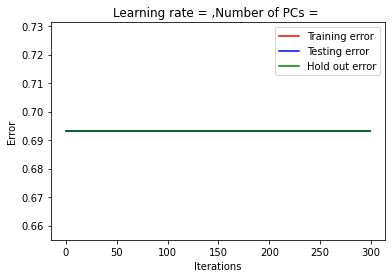

In [238]:
#Plot error/accuracy 
plt.plot(train_error,color = 'red',label = 'Training error')
plt.plot(test_error,color = 'blue',label = 'Testing error')
plt.plot(hold_out_error,color = 'green',label = 'Hold out error')
plt.title("Learning rate = ,Number of PCs = ")
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.legend()
plt.show()

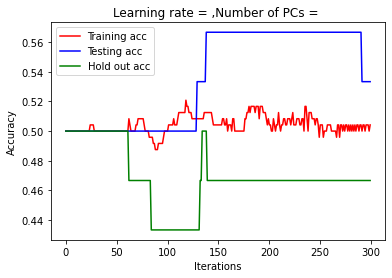

In [239]:
plt.plot(train_acc,color = 'red',label = 'Training acc')
plt.plot(test_acc,color = 'blue',label = 'Testing acc')
plt.plot(hold_out_acc,color = 'green',label = 'Hold out acc')
plt.title("Learning rate = ,Number of PCs = ")
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.show()